## This file is to read the loss.npz
```
In the .npz file, it have the different data.files
```
| __.npz__ named（） | type | shape |
|-------|-------|-------|
| loss | list | 单元3 |
| recon_loss | list | 单元6 |
| latent loss | list | 单元6 |
| mse_loss(the same as recon_loss) | list | 单元6 |

In [1]:
import numpy as np
import matplotlib.pyplot as plt


## This is for the loss plot
```bash
python .git
```

In [2]:
# array1 = data['loss']
# recon_loss = data['recon_loss']
# mse_loss= data['mse'] 
# #discount=0 mean that mse =recon_loss
# plt.plot(array1,color='blue',alpha=0.3,label='loss')
# plt.plot(recon_loss,color='red',alpha=0.4,label='recon_loss')

# plt.legend()
# plt.yscale('log')
# plt.title("plot loss")

In [1]:
"""
pde2d.py

PDE VAE model (PDEAutoEncoder module) for fitting data with 2 spatial dimensions.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn.modules.utils import _pair

from torch.nn.parameter import Parameter

import torch.nn as nn

from neuralop.models import FNO

def compl_mul2d(a, b):
    # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
    return torch.einsum("bixy,ioxy->boxy", a, b)

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def forward(self, x, size=None):
        if size==None:
            size = x.size(-1)

        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[2,3], norm="ortho")

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, size, size//2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)


        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(size, size), dim=[2,3], norm="ortho")
        return x

class SimpleBlock2d(nn.Module):
    def __init__(self, in_dim, out_dim, domain_size, modes1, modes2, width): # assumes square domain
        super(SimpleBlock2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2

        self.width_list = [width*2//4, width*3//4, width*4//4, width*4//4, width*5//4]
        self.size_list = [domain_size] * 5
        self.grid_dim = 2

        self.fc0 = nn.Linear(in_dim+self.grid_dim, self.width_list[0])

        self.conv0 = SpectralConv2d(self.width_list[0], self.width_list[1], self.modes1*4//4, self.modes2*4//4)
        self.conv1 = SpectralConv2d(self.width_list[1], self.width_list[2], self.modes1*3//4, self.modes2*3//4)
        self.conv2 = SpectralConv2d(self.width_list[2], self.width_list[3], self.modes1*2//4, self.modes2*2//4)
        self.conv3 = SpectralConv2d(self.width_list[3], self.width_list[4], self.modes1*2//4, self.modes2*2//4)
        self.w0 = nn.Conv1d(self.width_list[0], self.width_list[1], 1)
        self.w1 = nn.Conv1d(self.width_list[1], self.width_list[2], 1)
        self.w2 = nn.Conv1d(self.width_list[2], self.width_list[3], 1)
        self.w3 = nn.Conv1d(self.width_list[3], self.width_list[4], 1)

        self.fc1 = nn.Linear(self.width_list[4], self.width_list[4]*2)
        self.fc2 = nn.Linear(self.width_list[4]*2, self.width_list[4]*2)
        self.fc3 = nn.Linear(self.width_list[4]*2, out_dim)

    def forward(self, x):

        batchsize = x.shape[0]
        size_x, size_y= x.shape[1], x.shape[2]
        grid = self.get_grid(size_x, batchsize, x.device)
        size_list = self.size_list

        x = torch.cat((x, grid.permute(0, 2, 3, 1)), dim=-1)

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x, size_list[1])
        x2 = self.w0(x.view(batchsize, self.width_list[0], size_list[0]**2)).view(batchsize, self.width_list[1], size_list[0], size_list[0])
        # x2 = F.interpolate(x2, size=size_list[1], mode='trilinear')
        x = x1 + x2
        x = F.selu(x) 

        x1 = self.conv1(x, size_list[2])
        x2 = self.w1(x.view(batchsize, self.width_list[1], size_list[1]**2)).view(batchsize, self.width_list[2], size_list[1], size_list[1])
        # x2 = F.interpolate(x2, size=size_list[2], mode='trilinear')
        x = x1 + x2
        x = F.selu(x) 

        x1 = self.conv2(x, size_list[3])
        x2 = self.w2(x.view(batchsize, self.width_list[2], size_list[2]**2)).view(batchsize, self.width_list[3], size_list[2], size_list[2])
        # x2 = F.interpolate(x2, size=size_list[3], mode='trilinear')
        x = x1 + x2
        x = F.selu(x)

        x1 = self.conv3(x, size_list[4])
        x2 = self.w3(x.view(batchsize, self.width_list[3], size_list[3]**2)).view(batchsize, self.width_list[4], size_list[3], size_list[3])
        # x2 = F.interpolate(x2, size=size_list[4], mode='trilinear')
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.selu(x)
        x = self.fc2(x)
        x = F.selu(x)
        x = self.fc3(x)
        return x

    def get_grid(self, S, batchsize, device):
        gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
        gridx = gridx.reshape(1, 1, S, 1).repeat([batchsize, 1, 1, S])
        gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, S).repeat([batchsize, 1, S, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)


class Net2d(nn.Module):
    def __init__(self, in_dim, out_dim, domain_size, modes, width):
        super(Net2d, self).__init__()
        self.conv1 = SimpleBlock2d(in_dim, out_dim, domain_size, modes, modes, width)

    def forward(self, x):
        x = self.conv1(x)
        return x





class PeriodicPad1d(nn.Module):
    def __init__(self, pad, dim=-1):
        super(PeriodicPad1d, self).__init__()
        self.pad = pad
        self.dim = dim

    def forward(self, x):
        if self.pad > 0:
            front_padding = x.narrow(self.dim, x.shape[self.dim]-self.pad, self.pad)
            back_padding = x.narrow(self.dim, 0, self.pad)
            x = torch.cat((front_padding, x, back_padding), dim=self.dim)

        return x

class AntiReflectionPad1d(nn.Module):
    def __init__(self, pad, dim=-1):
        super(PeriodicPad1d, self).__init__()
        self.pad = pad
        self.dim = dim

    def forward(self, x):
        if self.pad > 0:
            front_padding = -x.narrow(self.dim, 0, self.pad).flip([self.dim])
            back_padding = -x.narrow(self.dim, x.shape[self.dim]-self.pad, self.pad).flip([self.dim])
            x = torch.cat((front_padding, x, back_padding), dim=self.dim)

        return x


class DynamicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, boundary_cond='periodic'):

        super(DynamicConv2d, self).__init__()

        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride) # not implemented
        self.padding = _pair(padding)
        self.dilation = _pair(dilation) # not implemented

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.boundary_cond = boundary_cond

        if (self.padding[0] > 0 or self.padding[1] > 0) and boundary_cond == 'periodic':
            assert self.padding[0] == int((self.kernel_size[0]-1)/2)
            assert self.padding[1] == int((self.kernel_size[1]-1)/2)
            self.pad = nn.Sequential(   PeriodicPad1d(self.padding[1], dim=-1), 
                                        PeriodicPad1d(self.padding[0], dim=-2))
        else:
            self.pad = None

    def forward(self, input, weight, bias):
        y = input

        if self.pad is not None:
            output_size = input.shape[-2:]
            y = self.pad(y)
        else:
            output_size = ( input.shape[-2] - (self.kernel_size[0]-1),
                            input.shape[-1] - (self.kernel_size[1]-1))
        image_patches = F.unfold(y, self.kernel_size, self.dilation, 0, self.stride).transpose(1, 2)
        y = image_patches.matmul(weight.view(-1, 
                                                self.in_channels * self.kernel_size[0] * self.kernel_size[1], 
                                                self.out_channels))
        if bias is not None:
            y = y + bias.view(-1, 1, self.out_channels)

        return y.transpose(1, 2).view(-1, self.out_channels, output_size[0], output_size[1])


class ConvPropagator(nn.Module):
    def __init__(self, hidden_channels, linear_kernel_size, nonlin_kernel_size, data_channels, stride=1,
                 linear_padding=0, nonlin_padding=0, dilation=1, groups=1, prop_layers=1, prop_noise=0., boundary_cond='periodic'):
        super(ConvPropagator, self).__init__()  # 此处调用父类的构造函数
        
        self.data_channels = data_channels
        self.prop_layers = prop_layers
        self.prop_noise = prop_noise
        self.boundary_cond = boundary_cond
        self.de_fno = FNO(n_modes=(128, 128), hidden_channels=10,
                in_channels=data_channels, out_channels=data_channels)

        assert nonlin_padding == int((nonlin_kernel_size-1)/2)
        if boundary_cond == 'crop' or boundary_cond == 'dirichlet0':
            self.padding = int((2+prop_layers)*nonlin_padding)

       

        self.conv_linear = DynamicConv2d(data_channels, data_channels, linear_kernel_size, stride,
                                    linear_padding, dilation, groups, boundary_cond) if linear_kernel_size > 0 else None

        self.conv_in = DynamicConv2d(data_channels, hidden_channels, nonlin_kernel_size, stride,
                                    nonlin_padding, dilation, groups, boundary_cond)

        self.conv_out = DynamicConv2d(hidden_channels, data_channels, nonlin_kernel_size, stride,
                                    nonlin_padding, dilation, groups, boundary_cond)

        if prop_layers > 0:
            self.conv_prop = nn.ModuleList([DynamicConv2d(hidden_channels, hidden_channels, nonlin_kernel_size, stride,
                                            nonlin_padding, dilation, groups, boundary_cond)
                                            for i in range(prop_layers)])

        self.cutoff = Parameter(torch.Tensor([1]))

    def _target_pad_2d(self, y, y0):
        y = torch.cat((y0[:,:,:self.padding, self.padding:-self.padding], 
                        y, y0[:,:,-self.padding:,  self.padding:-self.padding]), dim=-2)
        return torch.cat((y0[:,:,:,:self.padding], y, y0[:,:,:,-self.padding:]), dim=-1)

    def _antireflection_pad_1d(self, y, dim):
        front_padding = -y.narrow(dim, 0, self.padding).flip([dim])
        back_padding = -y.narrow(dim, y.shape[dim]-self.padding, self.padding).flip([dim])
        return torch.cat((front_padding, y, back_padding), dim=dim)

    def _f(self, y, linear_weight, linear_bias, in_weight, in_bias, 
                    out_weight, out_bias, prop_weight, prop_bias):
        y_lin = self.conv_linear(y, linear_weight, linear_bias) if self.conv_linear is not None else 0

        y = self.conv_in(y, in_weight, in_bias)
        y = F.leaky_relu(y, inplace=True)
        for j in range(self.prop_layers):
            y = self.conv_prop[j](y, prop_weight[:,j], prop_bias[:,j])
            y = F.leaky_relu(y, inplace=True)
        y = self.conv_out(y, out_weight, out_bias)

        return y + y_lin

    def forward(self, y0, linear_weight, linear_bias, 
                in_weight, in_bias, out_weight, out_bias, prop_weight, prop_bias, depth):
        if self.boundary_cond == 'crop':
            # requires entire target solution as y0 for padding purposes
            assert len(y0.shape) == 5
            assert y0.shape[1] == self.data_channels
            assert y0.shape[2] == depth
            y_pad = y0[:,:,0]
            y = y0[:,:,0, self.padding:-self.padding, self.padding:-self.padding]
        elif self.boundary_cond == 'periodic' or self.boundary_cond == 'dirichlet0':
            assert len(y0.shape) == 4
            assert y0.shape[1] == self.data_channels
            y = y0
        else:
            raise ValueError("Invalid boundary condition.")

        f = lambda y: self._f(y, linear_weight, linear_bias, in_weight, in_bias, 
                                        out_weight, out_bias, prop_weight, prop_bias)

        y_list = []
        for i in range(depth):
            if self.boundary_cond == 'crop':
                if i > 0:
                    y_pad = self._target_pad_2d(y, y0[:,:,i])
            elif self.boundary_cond == 'dirichlet0':
                y_pad = self._antireflection_pad_1d(self._antireflection_pad_1d(y, -1), -2)
      
            elif self.boundary_cond == 'periodic':
                y_pad = y
         

            ### Euler integrator
            dt = 1e-3 # NOT REAL TIME STEP, JUST HYPERPARAMETER
            noise = self.prop_noise * torch.randn_like(y) if (self.training and self.prop_noise > 0) else 0

           #y = y + self.cutoff * torch.tanh((dt * f(y_pad)) / self.cutoff) + noise
            test = self.de_fno(y)

            y = y + self.cutoff * (dt *  test) / self.cutoff
            y_list.append(y)


        return torch.stack(y_list, dim=-3)
class ResidualConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, padding_func, pad_input):
        super(ResidualConv3d, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, dilation=dilation)
        self.activation = nn.Tanh() if out_channels == 64 else nn.Softplus()
        self.pad_func = padding_func
        self.pad_input = pad_input

    def forward(self, x):
        residual = x
        x = self.pad_func(self.pad_input, dim=-1)(x)
        x = self.pad_func(self.pad_input, dim=-2)(x)
        x = self.conv(x)
        x = self.activation(x)
        if x.size() == residual.size():
            x += residual  # Apply residual connection if sizes match
        return x
class PDEAutoEncoder(nn.Module):
    def __init__(self, param_size=1, data_channels=1, data_dimension=2, hidden_channels=16, 
                        linear_kernel_size=0, nonlin_kernel_size=5, prop_layers=1, prop_noise=0., 
                        boundary_cond='periodic', param_dropout_prob=0.1, debug=False):

        assert data_dimension == 2

        super(PDEAutoEncoder, self).__init__()

        self.param_size = param_size
        self.data_channels = data_channels
        self.hidden_channels = hidden_channels
        self.linear_kernel_size = linear_kernel_size
        self.nonlin_kernel_size = nonlin_kernel_size
        self.prop_layers = prop_layers
        self.boundary_cond = boundary_cond
        self.param_dropout_prob = param_dropout_prob
        self.debug = debug
        #self.layer_norm = nn.LayerNorm([39, 60, 60])
      


        if param_size > 0:
            ### 3D Convolutional Encoder
            if boundary_cond =='crop' or boundary_cond == 'dirichlet0':
                pad_input = [0, 0, 0, 0]
                pad_func = PeriodicPad1d # can be anything since no padding is added
            elif boundary_cond == 'periodic':
                pad_input = [1, 2, 4, 8]
                pad_func = PeriodicPad1d
            else:
                raise ValueError("Invalid boundary condition.")
            self.encoder_blocks = nn.ModuleList()
           # self.encoder = nn.Sequential(   pad_func(pad_input[0], dim=-1),
                                            # pad_func(pad_input[0], dim=-2),
                                            # nn.Conv3d(data_channels, 8,  kernel_size=(3, 3, 3), dilation=1),
                                            # nn.Softplus(),

                                            # pad_func(pad_input[1], dim=-1),
                                            # pad_func(pad_input[1], dim=-2),
                                            # nn.Conv3d(8, 64,  kernel_size=(3, 3, 3), dilation=2),
                                            # nn.Tanh(),

                                            # pad_func(pad_input[2], dim=-1),
                                            # pad_func(pad_input[2], dim=-2),
                                            # nn.Conv3d(64, 64,  kernel_size=(3, 3, 3), dilation=4),
                                            # nn.Tanh(),

                                            # pad_func(pad_input[3], dim=-1),
                                            # pad_func(pad_input[3], dim=-2),
                                            # nn.Conv3d(64, 64, kernel_size=(3, 3, 3), dilation=8),
                                            # nn.Softplus(),
                                            # )
            channels = [data_channels, 8, 64, 64, 64]  # 输入和输出通道数
            dilations = [1, 2, 4, 8]
            for i in range(4):
                self.encoder_blocks.append(
                    ResidualConv3d(channels[i], channels[i+1], kernel_size=(3, 3, 3), 
                                dilation=dilations[i], padding_func=pad_func, pad_input=pad_input[i])
                )

            
            
            
            self.encoder_to_param = nn.Sequential(
                                                     nn.Conv3d(64, param_size,  kernel_size=(3, 3, 3), stride=1),
                                                  )
            self.encoder_to_logvar = nn.Sequential(
                                                    nn.Conv3d(64, param_size,  kernel_size=(3, 3, 3), stride=1),                                
            )

            ### Parameter to weight/bias for dynamic convolutions
            if linear_kernel_size > 0:
                self.param_to_linear_weight = nn.Sequential( nn.Linear(param_size, 16 * data_channels * data_channels),
                                        nn.Tanh(),
                                        nn.Linear(16 * data_channels * data_channels, 
                                            data_channels * data_channels * linear_kernel_size * linear_kernel_size)
                                        )

            self.param_to_in_weight = nn.Sequential( nn.Linear(param_size, 16 * data_channels * hidden_channels),
                                    nn.Tanh(),
                                    nn.Linear(16 * data_channels * hidden_channels, 
                                        data_channels * hidden_channels * nonlin_kernel_size * nonlin_kernel_size)
                                    )
            self.param_to_in_bias = nn.Sequential( nn.Linear(param_size, 4 * hidden_channels),
                                    nn.Tanh(),
                                    nn.Linear(4 * hidden_channels, hidden_channels)
                                    )

            self.param_to_out_weight = nn.Sequential( nn.Linear(param_size, 16 * data_channels * hidden_channels),
                                    nn.Tanh(),
                                    nn.Linear(16 * data_channels * hidden_channels, 
                                        data_channels * hidden_channels * nonlin_kernel_size * nonlin_kernel_size)
                                    )
            self.param_to_out_bias = nn.Sequential( nn.Linear(param_size, 4 * data_channels),
                                    nn.Softplus(),
                                    nn.Linear(4 * data_channels, data_channels)
                                    )

            if prop_layers > 0:
                self.param_to_prop_weight = nn.Sequential( nn.Linear(param_size, 16 * prop_layers * hidden_channels * hidden_channels),
                                        nn.Softplus(),
                                        nn.Linear(16 * prop_layers * hidden_channels * hidden_channels, 
                                            prop_layers * hidden_channels * hidden_channels * nonlin_kernel_size * nonlin_kernel_size)
                                        )
                self.param_to_prop_bias = nn.Sequential( nn.Linear(param_size, 4 * prop_layers * hidden_channels),
                                         nn.Softplus(),
                                        nn.Linear(4 * prop_layers * hidden_channels, prop_layers * hidden_channels)
                                        )

        ### Decoder/PDE simulator
        self.decoder = ConvPropagator(hidden_channels, linear_kernel_size, nonlin_kernel_size, data_channels, 
                                        linear_padding=int((linear_kernel_size-1)/2), 
                                        nonlin_padding=int((nonlin_kernel_size-1)/2), 
                                        prop_layers=prop_layers, prop_noise=prop_noise, boundary_cond=boundary_cond)
        
    def forward(self, x, y0, depth):

        #x = self.layer_norm(x)
        if self.param_size > 0:
            assert len(x.shape) == 5
            assert x.shape[1] == self.data_channels

            ### 3D Convolutional Encoder
            #encoder_out = self.encoder(x)
            # 使用自定义的卷积块进行编码
            encoder_out = x
            for block in self.encoder_blocks:
                encoder_out = block(encoder_out)

            logvar = self.encoder_to_logvar(encoder_out)
            logvar_size = logvar.shape
            logvar = logvar.view(logvar_size[0], logvar_size[1], -1)
            params = self.encoder_to_param(encoder_out).view(logvar_size[0], logvar_size[1], -1)

            if self.debug:
                raw_params = params

            # Parameter Spatial Averaging Dropout
            if self.training and self.param_dropout_prob > 0:
                mask = torch.bernoulli(torch.full_like(logvar, self.param_dropout_prob))
                mask[mask > 0] = float("inf")
                logvar = logvar + mask

            # Inverse variance weighted average of params
            weights = F.softmax(-logvar, dim=-1)
            params = (params * weights).sum(dim=-1)

            # Compute logvar for inverse variance weighted average with a correlation length correction
            correlation_length = 3 # estimated as receptive field of the convolutional encoder
            logvar = -torch.logsumexp(-logvar, dim=-1) \
                        + torch.log(torch.tensor(
                            max(1, (1 - self.param_dropout_prob)
                                    * min(correlation_length, logvar_size[-3])
                                    * min(correlation_length, logvar_size[-2])
                                    * min(correlation_length, logvar_size[-1])),
                            dtype=logvar.dtype, device=logvar.device))

            ### Variational autoencoder reparameterization trick
            if self.training:
                stdv = (0.5 * logvar).exp() * 0.1
                # Sample from unit normal
                z = params + stdv * torch.randn_like(stdv) 
            else:
                z = params

            ### Parameter to weight/bias for dynamic convolutions
            if self.linear_kernel_size > 0:
                linear_weight = self.param_to_linear_weight(z)
                linear_bias = None
            else:
                linear_weight = None
                linear_bias = None

            in_weight = self.param_to_in_weight(z)
            in_bias = self.param_to_in_bias(z)

            out_weight = self.param_to_out_weight(z)
            out_bias = self.param_to_out_bias(z)

            if self.prop_layers > 0:
                prop_weight = self.param_to_prop_weight(z).view(-1, self.prop_layers,
                                    self.hidden_channels * self.hidden_channels * self.nonlin_kernel_size * self.nonlin_kernel_size)
                prop_bias = self.param_to_prop_bias(z).view(-1, self.prop_layers, self.hidden_channels)
            else:
                prop_weight = None
                prop_bias = None

        else: # if no parameter used
            linear_weight = None
            linear_bias = None
            in_weight = None
            in_bias = None
            out_weight = None
            out_bias = None
            prop_weight = None
            prop_bias = None
            params = None
            logvar = None

        ### Decoder/PDE simulator
        y = self.decoder(y0, linear_weight, linear_bias, in_weight, in_bias, out_weight, out_bias, 
                                prop_weight, prop_bias, depth)

        if self.debug:
            return y, params, logvar, [in_weight, in_bias, out_weight, out_bias, prop_weight, prop_bias], \
                    weights.view(logvar_size), raw_params.view(logvar_size)

        return y, params, logvar


In [4]:
torch.cuda.reset_max_memory_allocated()  # 重置最大内存计数器

torch.cuda.reset_accumulated_memory_stats()  # 重置累积内存统计



/opt/conda/lib/python3.8/site-packages/torch/cuda/memory.py:303: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [3]:
model_parater =torch.load("fish_run_vp_fno4/best.tar")
model = PDEAutoEncoder(param_size=1, data_channels=2, data_dimension=2, hidden_channels=5, 
                        linear_kernel_size=0, nonlin_kernel_size=3, prop_layers=1, prop_noise=0., 
                        boundary_cond='dirichlet0', param_dropout_prob=0.1, debug=False)

In [4]:

model.load_state_dict(model_parater)
model = model.float().to("cuda")

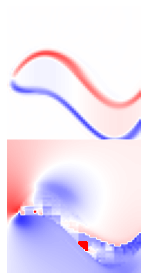

In [5]:
import numpy as np
import matplotlib.pyplot as plt
data_train = np.load("data/wave_vel/Fish_wave_vel_vp_data.npz")
plt.imshow(data_train["x"][0,:,10,:60,:60].reshape(-1,60),cmap="bwr",vmin=-1,vmax=1)
plt.axis('off')
plt.tight_layout()
plt.savefig("fish.png",dpi=250)

In [6]:
data_train_torch= torch.from_numpy(data_train["x"]).float()

In [7]:
data_train_torch= data_train_torch[0:1,:,:39,:60,:60].to("cuda")
data_train_torch.shape

torch.Size([1, 2, 39, 60, 60])

In [8]:
y0=data_train_torch[:,:,1,:80,:80]
y0.shape

torch.Size([1, 2, 60, 60])

In [9]:
y0.shape

torch.Size([1, 2, 60, 60])

In [10]:
a,u,logvar=model(data_train_torch,y0,50)

In [11]:
logvar


tensor([[-9.2242]], device='cuda:0', grad_fn=<AddBackward0>)

In [12]:
a.shape
from matplotlib.animation import FuncAnimation

In [13]:

class Ani():
    def __init__(self, vae_data, mean, logvar, true):
        self.vae_frames = vae_data  # [batch, 1, t, h, w]
        self.true_frames = true
        self.mu = mean
        self.var = np.exp(logvar)  # Assuming logvar is log variance
        self.fig, self.ax = plt.subplots(2, 1, figsize=(12, 12))  # 创建两个子图

    def init_ani(self):
        # 初始化动画的第一帧
        self.vae_image = self.ax[0].imshow(self.vae_frames[0, 1, 0, :, :], vmin=-1, vmax=1, cmap='bwr')
        self.true_image = self.ax[1].imshow(self.true_frames[0, 1, 0, :, :], vmin=-1, vmax=1, cmap='bwr')
        self.cbar_vae = self.fig.colorbar(self.vae_image, ax=self.ax[0], fraction=0.046, pad=0.04)
        self.cbar_true = self.fig.colorbar(self.true_image, ax=self.ax[1], fraction=0.046, pad=0.04)
        self.ax[0].set_title("VAE Generated")
        self.ax[1].set_title("True Frame")

    def update_ani(self, t):
        # 更新动画的每一帧
        self.vae_image.set_data(self.vae_frames[0, 1, t, :, :])  # 更新VAE生成的数据
        self.true_image.set_data(self.true_frames[0, 1, t, :, :])  # 更新真实数据
        self.ax[0].set_title(f"Step {t} cue {self.mu:.2e} and variance is {self.var:.2e}", fontsize=20)
        self.ax[1].set_title(f"Step {t} True Frame", fontsize=20)

    def save_ani(self, frames_number=38):
        # 创建并保存动画
        ani = FuncAnimation(self.fig, self.update_ani, frames=frames_number, init_func=self.init_ani, repeat=False)
        ani.save(f'VAE_video_p.gif', writer='imagemagick', fps=700)  # 注意: 根据你的环境配置，可能需要使用不同的writer

MovieWriter imagemagick unavailable; using Pillow instead.


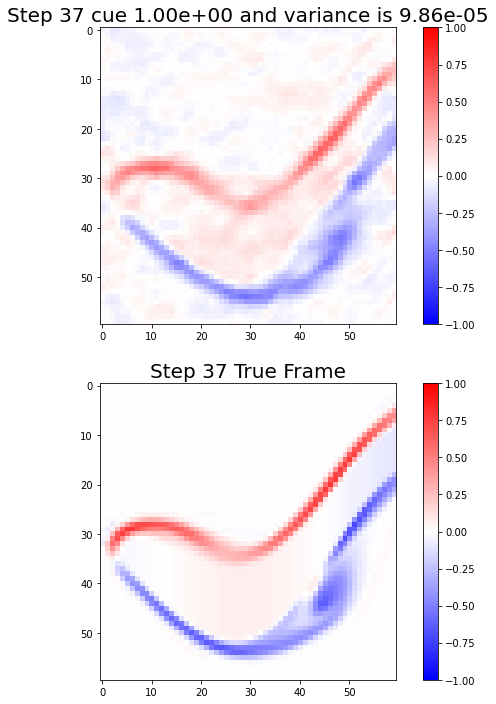

In [14]:
vae_data= a.cpu().detach().numpy()
data_train_numpy = data_train_torch.cpu().detach().numpy() 
ani = Ani(vae_data = vae_data,mean=u.item(),logvar=logvar.item(),true=data_train_numpy)
ani.save_ani()

In [1]:
plt.imshow(y0[:,:,:,:].cpu().detach().numpy().reshape(126,254),cmap="bwr",vmin=-1,vmax=1)

NameError: name 'plt' is not defined

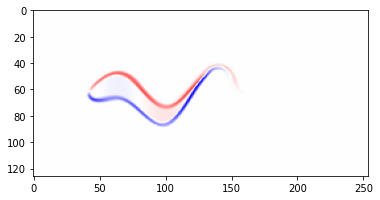

In [ ]:
plt.imshow(data_train_torch[:,:,59,:,:].cpu().detach().numpy().reshape(126,254),cmap="bwr",vmin=-1,vmax=1)

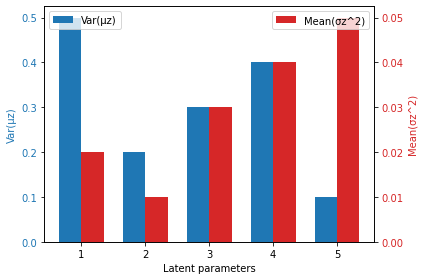

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 假设这些是你的数据
var_data = [0.5, 0.2, 0.3, 0.4, 0.1]  # 方差数据
mean_data = [0.02, 0.01, 0.03, 0.04, 0.05]  # 平均值数据
labels = ['1', '2', '3', '4', '5']  # 潜在参数标签

# 设置柱状图的位置和宽度
x = np.arange(len(labels))  # label位置
width = 0.35  # 柱状图的宽度

fig, ax1 = plt.subplots()

# 绘制方差数据的柱状图
rects1 = ax1.bar(x - width/2, var_data, width, label='Var(µz)', color='tab:blue')

# 使用相同的x轴，但不同的y轴绘制平均值数据的柱状图
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, mean_data, width, label='Mean(σz^2)', color='tab:red')

# 添加标签、标题和自定义x轴刻度标签
ax1.set_xlabel('Latent parameters')
ax1.set_ylabel('Var(µz)', color='tab:blue')
ax2.set_ylabel('Mean(σz^2)', color='tab:red')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 添加图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()


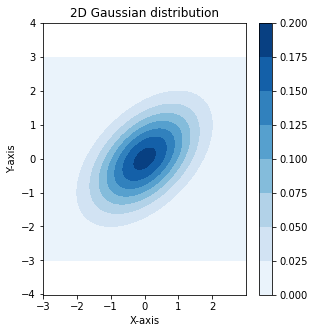

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm

# 设定随机数种子以便结果复现
np.random.seed(0)

# 两维度高斯分布的mu和sigma
mu_2d = np.array([0, 0])
sigma_2d = np.array([[1, 0.5], [0.5, 1]])

# 创建网格坐标
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

# 计算二维高斯分布
rv = multivariate_normal(mu_2d, sigma_2d)
z = rv.pdf(pos)

# 绘制二维高斯分布
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.contourf(x, y, z, cmap='Blues')
plt.colorbar()
plt.title('2D Gaussian distribution')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis('equal')

# 一维度高斯分布的mu和sigma
mu_1d = 0
sigma_1d = 1

# 创建一维坐标
x_1d = np.linspace(-3, 3, 1000)

# 计算一维高斯分布
pdf = norm(mu_1d, sigma_1d).pdf(x_1d)



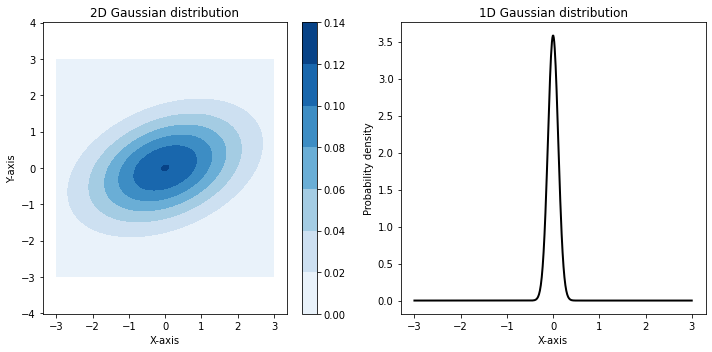

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm

# 设定随机数种子以便结果复现
np.random.seed(0)

# 两维度高斯分布的mu和sigma
mu_2d = np.array([0, 0])
sigma_2d = np.array([[2, 0.5], [0.5, 1]])

# 创建网格坐标
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

# 计算二维高斯分布
rv = multivariate_normal(mu_2d, sigma_2d)
z = rv.pdf(pos)

# 绘制二维高斯分布
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.contourf(x, y, z, cmap='Blues')
plt.colorbar()
plt.title('2D Gaussian distribution')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis('equal')

# 一维度高斯分布的mu和sigma
mu_1d = 0
sigma_1d = 0.1113

# 创建一维坐标
x_1d = np.linspace(-3, 3, 600)

# 计算一维高斯分布
pdf = norm(mu_1d, sigma_1d).cdf(x_1d)

# 绘制一维高斯分布
plt.subplot(1, 2, 2)
plt.plot(x_1d, pdf, 'k-', lw=2)
plt.title('1D Gaussian distribution')
plt.xlabel('X-axis')
plt.ylabel('Probability density')

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


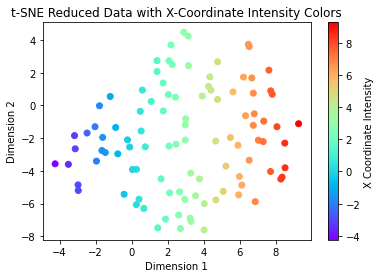

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assuming `data` is a (n_samples, 5) NumPy array with your high-dimensional data.
# For demonstration, using random data.
np.random.seed(0)
data = np.random.rand(100, 5)

# Initialize a t-SNE object.
tsne = TSNE(n_components=2, random_state=0)

# Reduce the dimensionality of the data.
data_reduced = tsne.fit_transform(data)

# Plot the reduced data, mapping the color to the x-coordinate.
# The larger the x-coordinate, the darker the color.
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=data_reduced[:, 0], cmap='rainbow')
plt.colorbar(label='X Coordinate Intensity')  # Show color scale
plt.title('t-SNE Reduced Data with X-Coordinate Intensity Colors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()
